# Linear Quadratic Regulator
Linear Quadratic Regulator (LQR) is widely used for stabilization of linear systems. With a quadratic cost function, it produces an optimal control law for linear systems. In its basic form, covered in this example notebook, the LQR drives (stabilizes or regulates) the state to zero. See the example notebook on `trajectory optimisation and stabilisation` for the application of finite-horizon LQR to trajectory tracking.

Consider a linear time-invariant (LTI) system of the form:

$$ \dot{x} = Ax + Bu $$

where $ x $ is the state, $ u $ is the control input, $ A $ is the state matrix, and $ B $ is the input matrix. The LQR is designed to minimize a quadratic cost function that is a weighted sum of the state and control variables. The cost function is defined as follows:

$$ J = \int_0^{\infty} (x^T Q x + u^T R u) dt $$

where $ Q $ and $ R $ are positive semi-definite weighting matrices representing penalties on deviations of the state $x$ and control $u$ from zero vectors, respectively. As $J$ is an integral from $[0, \infty]$, this is often referred to as the infinite-horizon LQR. It minimizes the cost function by solving the Riccati Differential Equation (RDE):

$$ A^T S + SA - SBR^{-1}B^T S + Q = 0, $$

where $ S $ is a positive definite matrix. The optimal control law is then given by:

$$ u = -R^{-1}B^T S x, $$

where $ S $ is the solution to the RDE. The optimal cost-to-go $J^*$, i.e. the minimum of $J$, is:

$$ J^* = x^T S x. $$

## Stabilization of nonlinear systems around equilibrium points

Besides direct application to linear systems as discussed above, the LQR is widely used for stabilization  of nonlinear systems around equilibrium points. The idea is to linearize the nonlinear system around an equilibrium point and then apply LQR to the linearized system. Consider a nonlinear system of the form:

$$ \dot{x} = f(x, u), $$

where $ f $ represents the nonlinear forward operator representing the dynamics. An equilibrium point is a state $ x_{eq} $ and a control input $ u_{eq} $ such that $ f(x_{eq}, u_{eq}) = 0 $. The linearized system around the equilibrium point $(x_{eq}, u_{eq})$ is given by:

$$ \delta \dot{x} = A \delta x + B \delta u, $$

where

$$ \delta x = x - x_{eq},$$
$$ \delta u = u - u_{eq},$$

$$ A = \frac{\partial f}{\partial x} \bigg|_{x_{eq}, u_{eq}}, $$

and

$$ B = \frac{\partial f}{\partial u} \bigg|_{x_{eq}, u_{eq}}, $$

are the Jacobians of the forward operator $ f $ with respect to the state and control vectors, respectively.

To learn more about LQR, the reader is referred to the following text, particularly Chapter 8:

>Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832). [Available online.](https://underactuated.csail.mit.edu/)

## Stabilizing a pendulum at the up-swing position

Consider a pendulum with a rigid rod of length $ L $ and a point mass $ m $ at the end. The pendulum is actuated by a torque $ u $ applied at the pivot. The damping coefficient is $b$. A schematic is shown below

<img src="../media/pendulum.png" alt="pendulum" style="width: 300px;"/>

The dynamics of this pendulum are given by:

$$ m L^2 \ddot{\theta} + b \dot{\theta} + m g L \sin(\theta) = u, $$
where $ \theta $ is the angle of the pendulum with the vertical, and $ g $ is the acceleration due to gravity. By defining $ \omega = \dot{\theta} $, and the state vector as:

\begin{equation}
x = 
\begin{bmatrix}
\theta \\ \omega
\end{bmatrix},
\end{equation}

the dynamics an be written as a set of first order differential equations:

\begin{equation}
\dot{x} = 
\begin{bmatrix}
\dot{\theta} \\ \dot{\omega}
\end{bmatrix} = 
f(x,u) = 
\begin{bmatrix}
\omega \\ -\dfrac{g}{L} \sin(\theta) - \dfrac{b}{m L^2} \omega +  \dfrac{u}{m L^2}
\end{bmatrix}.
\end{equation}

This system has two equilibrium points of interest, one at the up-swing position $ x_{eq} = \begin{bmatrix} \pi &  0 \end{bmatrix}^T $ and the other at the down-swing position $ x_{eq} = \begin{bmatrix} 0 & 0 \end{bmatrix}^T $, with the control input $u=0$ at both points. We will stabilize the pendulum at the up-swing position, which is an unstable equilibrium point.


### Linearization around an equilibrium point
While `collimator` provides convenient tools to linearize a system around an equilibrium point, we will can also manually compute the linearized system around the up-swing position. The jacobian matrices $A$ and $B$ are given by:

$$ A = \dfrac{\partial f}{\partial x} \bigg|_{x_{eq}, u_{eq}} = \begin{bmatrix} 0 & 1 \\ -\dfrac{g}{L} \cos(\pi) & -\dfrac{b}{m L^2} \end{bmatrix}, $$

and 

$$ B = \dfrac{\partial f}{\partial u} \bigg|_{x_{eq}, u_{eq}} = \begin{bmatrix} 0 \\ \dfrac{1}{m L^2} \end{bmatrix}. $$

In what follows, we show the implementation in Collimator.

In [1]:
import control
import jax.numpy as jnp
import collimator

from collimator.library import (
    linearize,
    FeedthroughBlock,
    Constant,
    Adder,
    LinearQuadraticRegulator,
)

from collimator.simulation import SimulatorOptions

import matplotlib.pyplot as plt

### Pendulum configuration

The model for the pendulum can be built either as a custom LeafSystem or from Collimator primitive blocks. For both these implementations, please see `collimator/models/pendulum.py`. You may also want to see the Collimator tutorials that showcase how to build models in Collimator. Here we just import the available model and an animation utility.

In [2]:
from collimator.models import Pendulum, animate_pendulum

config = {"m": 2.0, "g": 9.81, "L": 2.0, "b": 0.0}  # Pendulum parameters

# Equilibrium point for the up-swing position
u_eq = jnp.array([0.0])
x_eq = jnp.array([jnp.pi, 0.0])

# We choose the inititial state x0 as a small deviation from the equilibrium position.
x0 = x_eq + jnp.array([jnp.pi / 10, +0.5])

nx = 2  # size of state vector
nu = 1  # size of control vector

### Linearize around equilibrium points

For linearization, the collimator library provides an easy utility `linearize`. This takes a plant (LeafSystem or Diagram) and a context (containing the numerical values of all the model quantitities), and generates a linear time-invariant (LTI) system representing the linearized plant around the provided context. Thus, to create a linearized pendulum, we can provide a pendulum plant and a context representing the equilibrium to obtain the desired linear pendulum model around the equilibrium point.

In [3]:
pendulum = Pendulum(
    x0=x0, **config, input_port=True, full_state_output=True
)  # Create plant

# Fix the input_port to u_eq
with pendulum.input_ports[0].fixed(u_eq):
    # Create a base context
    base_context = pendulum.create_context()
    # Set the the continuous state to x_eq in the context
    eq_context = base_context.with_continuous_state(x_eq)
    # Call linearize for the pendulum plant and equilibrium context
    linear_pendulum = linearize(pendulum, eq_context)

A, B = linear_pendulum.A, linear_pendulum.B

# Visualize a state-space representation of the linear Pendulum
linear_pendulum

Initialized callback Pendulum_1_:Pendulum_1__ode with prereqs [1, 2, 8]
Initialized callback Pendulum_1_:u with prereqs []
Initialized callback Pendulum_1_:x with prereqs [2]
Initialized callback LTISystem_2_:u_0 with prereqs []
Initialized callback LTISystem_2_:LTISystem_2__ode with prereqs [1, 2, 8]
Initialized callback LTISystem_2_:y_0 with prereqs [0]


<LinearIOSystem:sys[6]:['u[0]']->['y[0]', 'y[1]']>

The last statement displays the matrices $A, B, C, D$ for the LTI system:

\begin{align}
\dot{x} &= Ax + Bu \\
y &= Cx + Du
\end{align}

as 

$$
\left(
\begin{array}{c|c}
A & B \\
\hline
C & D
\end{array}
\right)
$$

Since the output of the pendulum plant is the full state, i.e. $y = x$, we obtain $C$ as an identity matrix and $D$ as a zero matrix. Indeed, for LQR, we are not concernted with $C$ and $D$. We can confirm that the matrices $A$ and $B$ are identical to those obtained analytically.

### LQR

For creating the LQR controller, Collimator provides the `LinearQuadraticRegulator` block.

In [4]:
print(LinearQuadraticRegulator.__doc__)


    Linear Quadratic Regulator (LQR) for a continuous-time system:
            dx/dt = A x + B u.
    Computes the optimal control input:
            u = -K x,
    where u minimises the cost function over [0, ∞)]:
            J = ∫(x.T Q x + u.T R u) dt.

    Input ports:
        (0) x: state vector of the system.

    Output ports:
        (0) u: optimal control vector.

    Parameters:
        A: Array
            State matrix of the system.
        B: Array
            Input matrix of the system.
        Q: Array
            State cost matrix.
        R: Array
            Input cost matrix.
    


Having obtained the matrices $A$ and $B$ for the linear pendulum, we can use this block to instantiate an LQR. 

**Note:** It is important to consider that the LQR is obtianed for the linear system in the $\delta x$ and $\delta y$ coordinates, which represent deviations around the equilibrium point. Consequently, the input to the LQR block is $\delta x$ and its output is the control signal $\delta u$. We can use appropriate `Adder` and `Constant` blocks to implement these transformations within our diagram. Conceptually, our block diagrams looks as below.

<img src="../media/lqr_pendulum_block_diagram.png" alt="LQR block diagram for pendulum" style="width: 800px;"/>


This is implemented in code below.

In [5]:
Q = jnp.eye(nx)  # State cost matrix
R = 0.005 * jnp.eye(nu)  # Control input cost matrix

builder = collimator.DiagramBuilder()

plant = builder.add(Pendulum(x0=x0, **config, input_port=True, full_state_output=True))

x_eq_block = builder.add(Constant(x_eq, name="x_eq"))

delta_x = builder.add(Adder(2, operators="+-", name="delta_x"))

lqr = builder.add(LinearQuadraticRegulator(A, B, Q, R, name="lqr"))

u_eq_block = builder.add(Constant(u_eq, name="u_eq"))

controller = builder.add(
    Adder(2, operators="++", name="controller")
)  # names "u" in the block diagram above

builder.connect(plant.output_ports[0], delta_x.input_ports[0])
builder.connect(x_eq_block.output_ports[0], delta_x.input_ports[1])

builder.connect(delta_x.output_ports[0], lqr.input_ports[0])

builder.connect(lqr.output_ports[0], controller.input_ports[0])
builder.connect(u_eq_block.output_ports[0], controller.input_ports[1])

builder.connect(controller.output_ports[0], plant.input_ports[0])

diagram = builder.build()
diagram.pprint()

Initialized callback Pendulum_3_:Pendulum_3__ode with prereqs [1, 2, 8]
Initialized callback Pendulum_3_:u with prereqs []
Initialized callback Pendulum_3_:x with prereqs [2]
Initialized callback x_eq:out_0 with prereqs [0]
Initialized callback delta_x:u_0 with prereqs []
Initialized callback delta_x:u_1 with prereqs []
Initialized callback delta_x:y_0 with prereqs [22, 23]
Initialized callback lqr:u_0 with prereqs []
Initialized callback lqr:y_0 with prereqs [25]
Initialized callback u_eq:out_0 with prereqs [0]
Initialized callback controller:u_0 with prereqs []
Initialized callback controller:u_1 with prereqs []
Initialized callback controller:y_0 with prereqs [28, 29]
|-- root
    |-- Pendulum_3_(id=3)
    |-- x_eq(id=4)
    |-- delta_x(id=5)
    |-- lqr(id=6)
    |-- u_eq(id=7)
    |-- controller(id=8)


In [6]:
context = diagram.create_context()

recorded_signals = {
    "y": plant.output_ports[0],
    "u_opt": lqr.output_ports[0],
}

Tsolve = 3.0
options = SimulatorOptions(max_major_step_length=0.1)
results = collimator.simulate(
    diagram,
    context,
    (0.0, Tsolve),
    options=options,
    recorded_signals=recorded_signals,
)

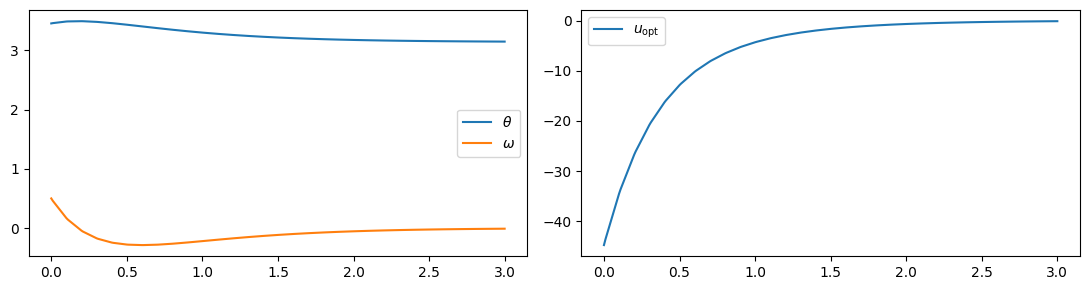

In [7]:
t = results.time
y = results.outputs["y"]
u_opt = results.outputs["u_opt"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))
ax1.plot(t, y[:, 0], label=r"$\theta$")
ax1.plot(t, y[:, 1], label=r"$\omega$")
ax2.plot(t, u_opt, label=r"$u_\mathrm{opt}$")
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

In [8]:
animate_pendulum(y[:, 0], u_opt, t)

## Move a planar quadrotor around to any x-y location

A schematic of the planar quadrotor (see [1] for details) is shown below

<img src="../media/planar_quadrotor.png" alt="planar quadrotor" style="width: 400px;"/>

The quadrotor is of mass $m$, and the moment of inertia about the center of mass is $I_B$. The distance from the center of mass to the rotors is $r$. The angle of the quadrotor with respect to the horizontal is $\theta$. The forces applied by the two rotors are $u_1$ and $u_2$. The dynamics of the quadrotor can be described as:

\begin{align}
        m \ddot{x} &= -(u_1 + u_2)\sin\theta,\\
        m \ddot{y} &= (u_1 + u_2)\cos\theta - mg,\\
        I_B \ddot\theta &= r (u_1 - u_2).
        \end{align}

Implemenation as a system of first order differential equations leads to a state vector of size 6: $\vec{x} = [x, y, \theta, \dot{x}, \dot{y}, \dot{\theta}]$. The control input vector is of size 2: $\vec{u} = [u_1, u_2]$.

### Equilibrium point

The quadrotor is in equilibrium when the forces applied by the rotors are such that the quadrotor is hovering at a given height. The forces are then such that the weight of the quadrotor is balanced by the forces applied by the rotors. The equilibrium point is then given by:

$$ u_{eq} = \left[\frac{m g}{2}, \frac{m g}{2}\right], \quad x_{eq} = [x, y, 0, 0, 0, 0]. $$

In the equilibrium state, note that the coordinates of the quadrotor $x$ and $y$ are *arbitrary*, and the angle $\theta$ is zero (horizontal orientation at hover). Thus any chosen $(x, y)$ can be used to define the equilibrium point. Furthremote, if we were to use the target location $(x,y)$ in the equilibrium point, we can make the quadrotor arrive at this location with LQR since the LOR will drive the $\delta x$ and $\delta y$ to zeros.

**References**:
> [1] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832). [Available online.](https://underactuated.csail.mit.edu/)

### Quadtorotor configuration

The model for the planar quadrotor can be built either as a custom LeafSystem or from Collimator primitive blocks. For the LeafSystem implementation, please see `collimator/models/quadrotor.py`. You may also see the Collimator tutorials that showcase how to build models in Collimator. Here we just import the available model and an animation utility. We follow exactly the same steps as with the Pendulum model.

In [9]:
from collimator.models import PlanarQuadrotor, animate_planar_quadrotor

config = {"m": 1.0, "I_B": 1.0, "r": 0.5, "g": 9.81}  # quadrotor parameters

nx = 6  # state vector size
nu = 2  # input vector size

weight = config["m"] * config["g"]

# Equilibrium point -- we schoose to move the quadrotor to (-1.0, -0.5)
u_eq = (weight / nu) * jnp.ones(nu)
x_eq = jnp.array([-1.0, -0.5] + [0.0] * 4)

x0 = jnp.array(
    [1.5, 1.5, jnp.pi / 4.0] + [0.5] * 3
)  # starting position of the quadrotor

### Linearize

Same procedure as that for the pendulum

In [10]:
planar_quadcopter = PlanarQuadrotor(**config, name="planar_quadrotor")

# Fix the input_port to u_eq
with planar_quadcopter.input_ports[0].fixed(u_eq):
    # Create a base context
    base_context = planar_quadcopter.create_context()
    # Set the the continuous state to x_eq in the context
    eq_context = base_context.with_continuous_state(x_eq)
    # Call linearize for the pendulum plant and equilibrium context
    linear_planar_quadcopter = linearize(planar_quadcopter, eq_context)

A, B = linear_planar_quadcopter.A, linear_planar_quadcopter.B

Initialized callback planar_quadrotor:u with prereqs []
Initialized callback planar_quadrotor:planar_quadrotor_ode with prereqs [1, 2, 8]
Initialized callback planar_quadrotor:y_0 with prereqs [2]
Initialized callback LTISystem_11_:u_0 with prereqs []
Initialized callback LTISystem_11_:LTISystem_11__ode with prereqs [1, 2, 8]
Initialized callback LTISystem_11_:y_0 with prereqs [0]


### LQR

Same procedure as that for the pendulum

In [11]:
Q = jnp.diag(
    jnp.array([10, 10, 10, 1, 1, config["r"] / 2.0 / jnp.pi])
)  # state cost matrix
R = jnp.array([[0.1, 0.05], [0.05, 0.1]])  # control input cost matrix

builder = collimator.DiagramBuilder()

plant = builder.add(PlanarQuadrotor(**config, name="planar_quadrotor"))

x_eq_block = builder.add(Constant(x_eq, name="x_eq"))

delta_x = builder.add(Adder(2, operators="+-", name="delta_x"))

lqr = builder.add(LinearQuadraticRegulator(A, B, Q, R, name="lqr"))

u_eq_block = builder.add(Constant(u_eq, name="u_eq"))

controller = builder.add(Adder(2, name="controller"))


builder.connect(plant.output_ports[0], delta_x.input_ports[0])
builder.connect(x_eq_block.output_ports[0], delta_x.input_ports[1])

builder.connect(delta_x.output_ports[0], lqr.input_ports[0])

builder.connect(lqr.output_ports[0], controller.input_ports[0])
builder.connect(u_eq_block.output_ports[0], controller.input_ports[1])

builder.connect(controller.output_ports[0], plant.input_ports[0])

diagram = builder.build()
diagram.pprint()

Initialized callback planar_quadrotor:u with prereqs []
Initialized callback planar_quadrotor:planar_quadrotor_ode with prereqs [1, 2, 8]
Initialized callback planar_quadrotor:y_0 with prereqs [2]
Initialized callback x_eq:out_0 with prereqs [0]
Initialized callback delta_x:u_0 with prereqs []
Initialized callback delta_x:u_1 with prereqs []
Initialized callback delta_x:y_0 with prereqs [41, 42]
Initialized callback lqr:u_0 with prereqs []
Initialized callback lqr:y_0 with prereqs [44]
Initialized callback u_eq:out_0 with prereqs [0]
Initialized callback controller:u_0 with prereqs []
Initialized callback controller:u_1 with prereqs []
Initialized callback controller:y_0 with prereqs [47, 48]
|-- root
    |-- planar_quadrotor(id=12)
    |-- x_eq(id=13)
    |-- delta_x(id=14)
    |-- lqr(id=15)
    |-- u_eq(id=16)
    |-- controller(id=17)


In [12]:
context = diagram.create_context()
context = context.with_continuous_state([x0])

recorded_signals = {
    "x": plant.output_ports[0],
    "u_opt": controller.output_ports[0],
}

Tsolve = 5.0
options = SimulatorOptions(max_major_step_length=0.1)

results = collimator.simulate(
    diagram,
    context,
    (0.0, Tsolve),
    options=options,
    recorded_signals=recorded_signals,
)

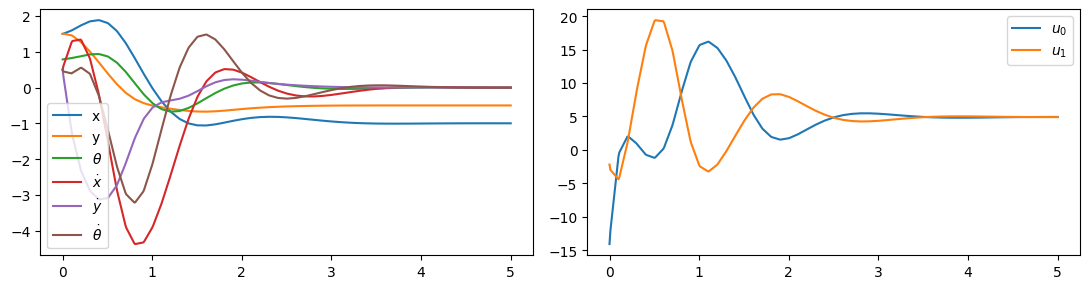

In [13]:
t = results.time
x = results.outputs["x"]
u_opt = results.outputs["u_opt"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))
ax1.plot(t, x[:, 0], label=r"x")
ax1.plot(t, x[:, 1], label=r"y")
ax1.plot(t, x[:, 2], label=r"$\theta$")
ax1.plot(t, x[:, 3], label=r"$\dot{x}$")
ax1.plot(t, x[:, 4], label=r"$\dot{y}$")
ax1.plot(t, x[:, 5], label=r"$\dot{\theta}$")

ax2.plot(t, u_opt[:, 0], label=r"$u_0$")
ax2.plot(t, u_opt[:, 1], label=r"$u_1$")

ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

In [14]:
animate_planar_quadrotor(
    x, x_eq, xlim=[-1.5, 2.0], ylim=[-1.0, 2.0], figsize=(6, 5), interval=50
)